In [24]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [25]:
import numpy as np
import pandas as pd

In [26]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [28]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [29]:
# declare a base
Base = automap_base()

In [30]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables

In [31]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [34]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [35]:
# Columns in Measurement
columns = inspector.get_columns('measurement')
for column in columns:
        print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [36]:
# Columns in Station
columns = inspector.get_columns('station')
for column in columns:
        print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_date

('2017-08-23')

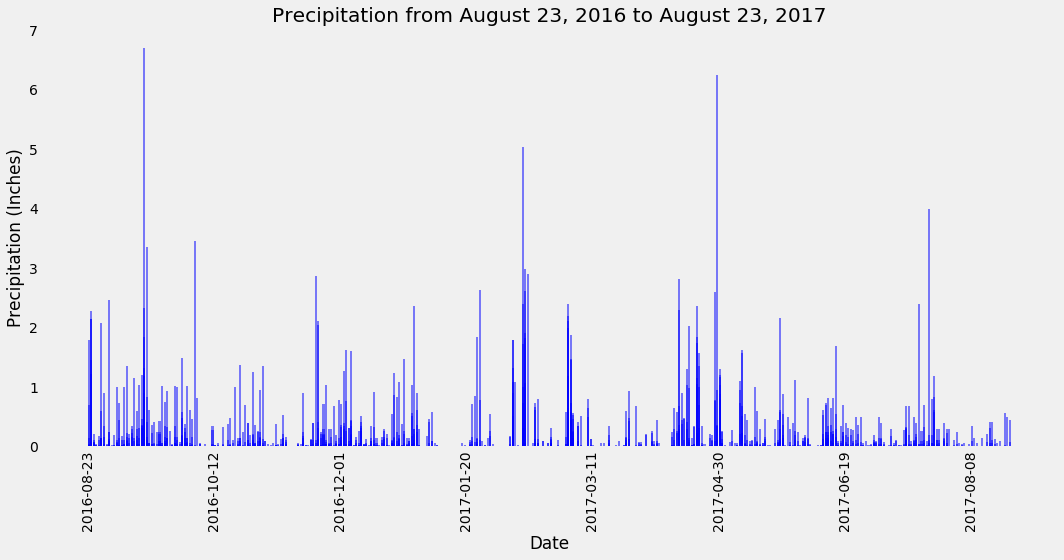

In [38]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
date_format = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
querydate = dt.date(date_format.year -1, date_format.month, date_format.day)

dates = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= querydate).\
    order_by(Measurement.date.asc()).all()
dates

# Save the query results as a Pandas DataFrame and set the index to the date column
org_df1 = pd.DataFrame(dates)
org_df2 = org_df1.set_index('date')
org_df2

precip_df = org_df2.dropna()
precip_df

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = precip_df.index
y_axis = precip_df['prcp']

plt.figure(figsize=(15,8))
plt.bar(x_axis, y_axis, color='b', alpha=0.5, align='edge')

major_ticks = np.arange(0,400,50)
plt.xticks(major_ticks, rotation='vertical')

plt.title("Precipitation from August 23, 2016 to August 23, 2017")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")

plt.tight_layout()
plt.grid()
plt.savefig("Images/one_year_precip.png")
plt.show()

In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [40]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [41]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]

active_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Measurement.station,
        func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

most_active = session.query(*sel).\
    filter(Measurement.station == active_station[0][0]).all()

most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

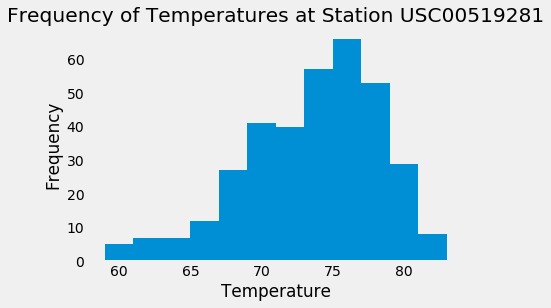

In [44]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_records = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= querydate).\
    filter(Measurement.station == active_station[0][0]).all()

temp_records

temp_data = pd.DataFrame(temp_records)
temp_data

plt.hist(temp_data['tobs'], bins=12)
plt.title("Frequency of Temperatures at Station USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.grid()
plt.savefig("Images/temp_frequency_one_year.png")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
